In [ ]:
## Run 
import numpy as np
import tracing_tools as tr

#import pytools as pt
tstep = 1335

#fields = tr.load_fields(tstep)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


RE=6371000

dt = 0.05
t_start,t_end=1335,1336
n_prt=3
vth=400e+3

xvp_store={}
X0={}

n_prt=5
for prt in range(n_prt):
    print(prt)
    
    ### initialization
    initial_position=[-11*RE-0.3*RE*prt, 0*RE-prt*RE, 0.7*RE]    
    rand_seed = abs(np.random.randn(3))
    initial_velocity=[-vth*rand_seed[0],vth*rand_seed[1],-vth*rand_seed[2]]
    print('initial position (m):', initial_position)
    print('initial velocity (m/s):', initial_velocity)
    X0a = np.array(initial_position+initial_velocity)
    X0[prt]=X0a
    print(X0a)
    x,y,z=[initial_position[0]],[initial_position[1]],[initial_position[2]]
    vx,vy,vz=[initial_velocity[0]],[initial_velocity[1]],[initial_velocity[2]]
    
    
    ### subcycle for updating fields every secvond
    for t in range(t_start,t_end):
        
        e,b,extends,time,size = tr.load_fields(t)
        
        N=1/dt
        t_integration=np.linspace(0,1,int(N))
        print(t_integration)

        P = odeint(tr.lorentz_force, X0[prt], t_integration, args=(e,b,extends))
        x_s, y_s, z_s, vx_s,vy_s,vz_s = P.T
        
        print('x_s, y_s, z_s, vx_s,vy_s,vz_s',x_s, y_s, z_s, vx_s,vy_s,vz_s)
        X0[prt]=x_s[-1], y_s[-1], z_s[-1], vx_s[-1],vy_s[-1],vz_s[-1]
        
        x=np.concatenate([x, x_s])
        y=np.concatenate([y, y_s])
        z=np.concatenate([z, z_s])
        vx=np.concatenate([vx, vx_s])
        vy=np.concatenate([vy, vy_s])
        vz=np.concatenate([vz, vz_s])

        #### patch for break in case of particle leaving the domain
        if (abs(abs(x_s[-1])-abs(extends[0]))<RE/2 or abs(abs(x_s[-1])-abs(extends[1]))<RE/2 or 
            abs(abs(y_s[-1])-abs(extends[2]))<RE/2 or abs(abs(y_s[-1])-abs(extends[3]))<RE/2 or 
            abs(abs(z_s[-1])-abs(extends[4]))<RE/2 or abs(abs(z_s[-1])-abs(extends[5]))<RE/2):
            print('leaving the domain')
            break


    x,y,z,vx,vy,vz = np.array(x),np.array(y),np.array(z),np.array(vx),np.array(vy),np.array(vz)
    xv_store=x,y,z,vx,vy,vz    
    xvp_store[prt] = xv_store






0
initial position (m): [-70081000.0, 0, 4459700.0]
initial velocity (m/s): [np.float64(-466210.0658443955), np.float64(489709.43356523913), np.float64(-650858.20532196)]
[-70081000.                 0.           4459700.
   -466210.0658444     489709.43356524   -650858.20532196]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'float'>
Ex  <class 'flo

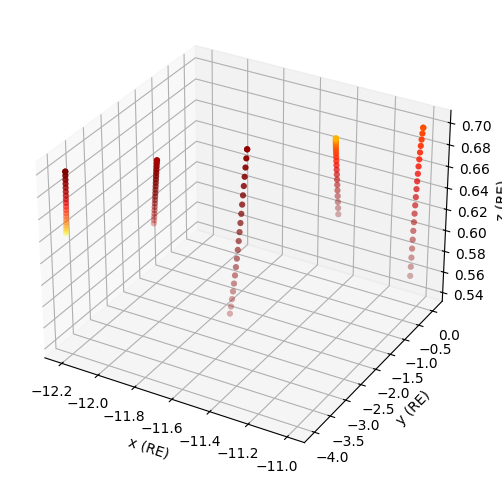

In [3]:
# Plot saved traces (calls `tr.plot_trace`)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

if not xvp_store:
    print('No traces in xvp_store to plot')
else:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    for prt, store in xvp_store.items():
        tr.plot_trace(ax, store)
    ax.set_xlabel('x (RE)')
    ax.set_ylabel('y (RE)')
    ax.set_zlabel('z (RE)')
    plt.show()

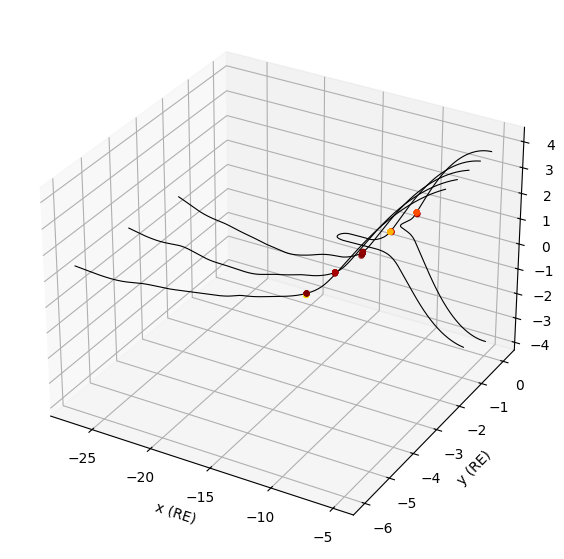

In [5]:
# Trace and plot magnetic field lines alongside particle traces
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# load fields for the same tstep used in tracing
e,b,extends,time,size = tr.load_fields(tstep)
xx,yy,zz = tr.get_axes(extends, size)

# build interpolators for B components
bx_int = RegularGridInterpolator((xx,yy,zz), b[:,:,:,0], bounds_error=False, fill_value=np.nan)
by_int = RegularGridInterpolator((xx,yy,zz), b[:,:,:,1], bounds_error=False, fill_value=np.nan)
bz_int = RegularGridInterpolator((xx,yy,zz), b[:,:,:,2], bounds_error=False, fill_value=np.nan)

def trace_field_line(seed, max_steps=2000, ds=RE*0.02, bidirectional=True):
    pos0 = np.asarray(seed, dtype=float).ravel()

    def _trace_dir(pos_start, steps, sign=1):
        pos = pos_start.copy()
        seg = [pos.copy()]
        for i in range(steps):
            bx = tr._interp_scalar(bx_int, pos)
            by = tr._interp_scalar(by_int, pos)
            bz = tr._interp_scalar(bz_int, pos)
            B = np.array([bx,by,bz], dtype=float)
            if np.any(np.isnan(B)):
                break
            n = np.linalg.norm(B)
            if n == 0:
                break
            pos = pos + sign * (ds * (B / n))
            seg.append(pos.copy())
        return np.array(seg)

    if not bidirectional:
        return _trace_dir(pos0, max_steps, sign=1)

    # split steps between backward and forward traces
    steps_fwd = max_steps // 2
    steps_bwd = max_steps - steps_fwd
    fwd = _trace_dir(pos0, steps_fwd, sign=1)
    bwd = _trace_dir(pos0, steps_bwd, sign=-1)
    # combine: reverse the backward segment (so it goes from far->seed) then append forward excluding duplicate seed
    if bwd.size == 0:
        return fwd
    combined = np.vstack((bwd[::-1], fwd[1:]))
    return combined

# choose seeds: use first positions from each stored particle if available
seeds = []
for prt, store in xvp_store.items():
    x, y, z = store[0][0], store[1][0], store[2][0]
    seeds.append([x,y,z])

# plot particles and field lines together
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
# particle traces
for prt, store in xvp_store.items():
    tr.plot_trace(ax, store)
# field lines
for s in seeds:
    line = trace_field_line(s, max_steps=1500, ds=RE*0.02, bidirectional=True)
    if line.size > 0:
        ax.plot(line[:,0]/RE, line[:,1]/RE, line[:,2]/RE, color='k', linewidth=0.8)

ax.set_xlabel('x (RE)')
ax.set_ylabel('y (RE)')
ax.set_zlabel('z (RE)')
plt.show()
